# Imports

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [125]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries, helpers
from nnpde.utils.logs import enable_logging, logging 
from nnpde.problems import DirichletProblem 

In [136]:
enable_logging(10)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

2018-12-18 12:16:49,907 - root - INFO - logs - logging enabled for level: 10


# Setup

In [128]:
# Define train dimension
N = 16

# Initialize f: we use a zero forcing term for training
f = torch.zeros(1, 1, N, N)

# For each problem instance define number of iteration to perform to obtain the solution
nb_problem_instances = 30
problem_instances = [DirichletProblem(k=k) for k in np.random.randint(1, 20, nb_problem_instances)]

In [129]:
B_idx = problem_instances[1].B_idx

In [130]:
net = nn.Sequential(nn.Conv2d(1, 1, 3, padding=1, bias=False))
G = helpers.build_G(B_idx)
T = helpers.build_T(N)
H = helpers.conv_net_to_matrix(net, N)
I = np.eye(N)

In [86]:
helpers.spectral_radius(T+G.dot(H).dot(T)-G.dot(H))

1.2129688926293802

# Train using the class

In [137]:
import nnpde.model as M 
reload(M)

# TODO fit would idealy take X, y, (u_0 and u_*)
model = M.JacobyWithConv(max_iters=100, batch_size=10, learning_rate = 1e-6, nb_layers=1).fit(problem_instances)
losses = model.losses
losses

2018-12-18 12:16:54,041 - root - INFO - model - iter 0 with total loss 936.13330078125


[936.13330078125,
 813.20556640625,
 701.6061401367188,
 667.4849853515625,
 640.8649291992188,
 612.9937133789062,
 598.1324462890625,
 581.2841186523438,
 569.0789794921875,
 560.7681274414062,
 552.1292724609375,
 546.2914428710938,
 539.993896484375,
 534.6087646484375,
 527.9120483398438,
 522.8011474609375,
 518.2753295898438,
 512.0675659179688,
 507.2275085449219,
 503.1369323730469,
 500.8008117675781,
 498.5404052734375,
 494.8836669921875,
 492.93145751953125,
 490.49700927734375,
 486.6615295410156,
 483.4446716308594,
 481.01861572265625,
 479.3982238769531,
 476.223876953125,
 473.8343200683594,
 471.64208984375,
 468.30059814453125,
 465.6372375488281,
 463.4850769042969,
 461.0035705566406,
 458.8819274902344,
 456.94720458984375,
 453.36199951171875,
 450.70208740234375,
 448.6743469238281,
 446.5971374511719,
 443.330322265625,
 441.28564453125,
 438.2698059082031,
 436.38818359375,
 433.635498046875,
 430.51953125,
 427.42431640625,
 424.0999755859375,
 421.446533203

In [75]:
print(losses)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [11]:
# TODO conv_u and Hu should be more or less the same, right? but they are clearly not...
some_u = problem_instances[0].initial_u

conv_u = im.reset_boundary(model.net(some_u)

H = helpers.conv_net_to_matrix(model.net, model.N)

GHu = g.dot(np.dot(H, some_u.view(-1).detach().numpy()))

all((conv_u.view(-1).detach().numpy() - Hu) < 1e-4)

SyntaxError: invalid syntax (<ipython-input-11-1515b1a39e0d>, line 5)

CHECK VALUES, now the error is very small , only problems may be at boundary nodes

In [ ]:
print(conv_u.view(-1).detach().numpy() - Hu)

final loss is 159376.453125


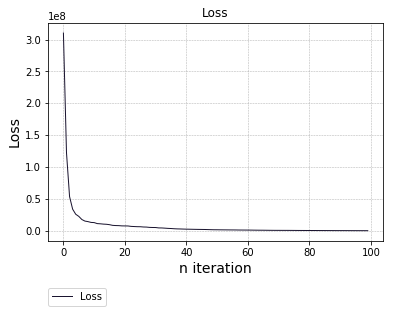

In [135]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Train without using the class

In [ ]:
from nnpde import metrics 
# Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
# TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?
model = M.JacobyWithConv(max_iters=1000, batch_size=10)
net = model.net
optim = model.optim
losses = []
for _ in range(100):
    net.zero_grad()
    loss = torch.zeros(1)
    prev_total_loss = 0

    batch_size = 1
    u_list = [None] * batch_size
    
    # Sample problem_instances
    problem_idx = np.random.choice(np.arange(nb_problem_instances), batch_size, replace = 0)

    for i in range(batch_size):

        idx = problem_idx[i]
        problem_instance = problem_instances[idx]
        
        B_idx = problem_instance.B_idx
        B = problem_instance.B
        f = problem_instance.f
        initial_u = problem_instance.initial_u
        k = problem_instance.k
        ground_truth = problem_instance.ground_truth
        
        # Compute the solution with the updated weights      
        u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)
        
        #H = helpers.build_diagH_from_net(net,N)
        #T = helpers.get_T(N)
        #
        #spectral_norm = helpers.calculate_spectral_radius(T,H)
        #ex = 0
        #        
        #if spectral_norm > 1:
        #    ex = np.nan_to_num(np.inf)

        # Define the loss, CHECK if it is correct wrt paper
        loss = loss + F.mse_loss(ground_truth, u_list[i])#+ex
    


    # Backpropagation
    loss.backward(retain_graph =  False)

    # SGD step
    optim.step()
    
    total_loss = metrics.compute_loss(net, problem_instances)
    
    # Exit optimization 
    tol = 1e-2
    if total_loss.item() <= tol or total_loss.item() - prev_total_loss < tol:
        break


    # Store lossses for visualization
    losses.append(total_loss.item())
    prev_loss = total_loss.item()

for name, param in net.named_parameters():
    print(name, param)

Plot the losses

In [ ]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [ ]:
N = 50
nb_iters = 2000

B_idx, B = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(model.net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

In [ ]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)
net = model.net

In [ ]:
%%timeit

u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = F.mse_loss(gtt, u_k_old)
k_count_old = 1
count_old = 1
# old method 
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = F.mse_loss(gtt, u_k_old)
    k_count_old += 1

In [ ]:
%%timeit

u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = F.mse_loss(gtt, u_k_new)
k_count_new = 1


# new method

while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = F.mse_loss(gtt, u_k_new)
    k_count_new += 1

In [ ]:
# This is not correct, but we have to look for a way to access the variables inside timeit

print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

In [ ]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
(gtt.view(N,N) - output.view(N,N)).mean()

Test on L-shape domain

In [ ]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

In [ ]:
helpers.plot_solution(gtt,output,N)

In [ ]:
multiply_adds = 1

def count_conv2d(shapex, shapey,in_channels = 1,out_channels = 1,kernel_size = (3,3)):
    
    cin = in_channels
    cout = out_channels
    kh, kw = kernel_size
    batch_size = shapex[0]

    out_w = shapey[2]
    out_h = shapey[3]

    # ops per output element
    # kernel_mul = kh * kw * cin
    # kernel_add = kh * kw * cin - 1
    
    kernel_ops = multiply_adds * kh * kw * cin
    ops_per_element = kernel_ops

    # total ops
    # num_out_elements = y.numel()
    output_elements = batch_size * out_w * out_h * cout
    total_ops = output_elements * ops_per_element

    # in case same conv is used multiple times
    total_ops += torch.Tensor([int(total_ops)])
    
    return total_ops

In [ ]:
def compare_flops(n,n_iter_conv,n_iter_jac,layers):
    #flops, params = profile(net, input_size=input_shape)
    flop_conv = (count_conv2d((1,1,256,256),(1,1,3,3)) + 2*n**2 + 4) * n_iter_conv # 9 operations for each convolution, and we perform n^2 convolutions in total for each layer + 6 operations for the jacobi iteration step
    flop_jac = (7 * n**2) * n_iter_jac # For each u_ij, we add its 4 neighbors + forcing term + resetting the boundaries
    return flop_conv/flop_jac

In [ ]:
compare_flops(16,k_count_new,k_count_old,3)